In [1]:
using BenchmarkTools

include("base.jl")
include("to_newick.jl")
include("to_vector.jl");

In [2]:
v = sample_v(1024)
newick = to_newick(v)
v_reconstructed = to_vector(newick);

In [3]:
@benchmark to_newick(v) setup=(v=$v)

BenchmarkTools.Trial: 7438 samples with 1 evaluation.
 Range (min … max):  505.400 μs …   4.187 ms  ┊ GC (min … max): 0.00% … 80.48%
 Time  (median):     588.300 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   663.005 μs ± 308.873 μs  ┊ GC (mean ± σ):  6.34% ± 10.90%

  ▆█▇▇▆▅▄▃▂▂▂▁▁ ▁                                               ▂
  █████████████████▇▇▇▆▅▄▄▄▃▁▃▄▃▁▁▁▃▁▁▃▃▁▁▁▁▁▁▁▅▅▅▆▅▆▆▅▅▆▅▅▆▆▅▆ █
  505 μs        Histogram: log(frequency) by time       2.53 ms <

 Memory estimate: 1.02 MiB, allocs estimate: 10265.

In [4]:
@benchmark to_vector(newick) setup=(newick=$newick)

BenchmarkTools.Trial: 2714 samples with 1 evaluation.
 Range (min … max):  1.341 ms …   7.025 ms  ┊ GC (min … max):  0.00% … 55.09%
 Time  (median):     1.513 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   1.832 ms ± 691.061 μs  ┊ GC (mean ± σ):  11.20% ± 16.30%

  ▅█▆▅▄▄▄▃▃▂▁▁ ▁  ▁ ▁▁      ▁▁▁▁▁                             ▁
  ███████████████▇████▇▇██▇███████████████▆▇▆▅▄▅▇▅▅▃▄▄▁▄▅▄▃▃▃ █
  1.34 ms      Histogram: log(frequency) by time      4.48 ms <

 Memory estimate: 5.54 MiB, allocs estimate: 6166.

In [5]:
all(v_reconstructed .== v)

true

## Benchmark to_newick

In [3]:
MIN_LEAVES = 5
MAX_LEAVES = 1000
STEP_LEAVES = 50

N_TIMES = 100
N_REPEATS = 7;

all_leaves = MIN_LEAVES:STEP_LEAVES:MAX_LEAVES |> collect;

### Julia

In [4]:
perfs_jl_itr = zeros(length(all_leaves))
perfs_jl_rec = zeros(length(all_leaves))

for (i, nleaves) in enumerate(all_leaves)
    v = sample_v(nleaves)
    
    # compile
    to_newick_old(v)
    to_newick(v)
    
    # bench
    res_itr = @benchmark to_newick_old(v) setup=(v=$v) samples=N_TIMES * N_REPEATS
    res_rec = @benchmark to_newick(v) setup=(v=$v) samples=N_TIMES * N_REPEATS
    
    # convert ns to ms and take mean of evaluations
    perfs_jl_itr[i] = mean(res_itr.times) / 1e6
    perfs_jl_rec[i] = mean(res_rec.times) / 1e6
end

In [5]:
using PyPlot

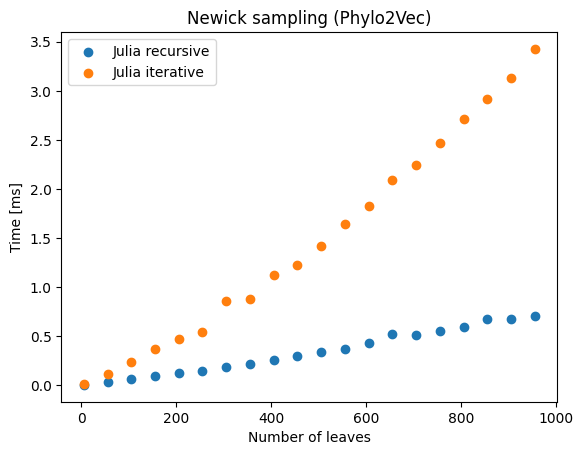

In [6]:
clf()

scatter(all_leaves, perfs_jl_rec, label="Julia recursive")
scatter(all_leaves, perfs_jl_itr, label="Julia iterative")

title("Newick sampling (Phylo2Vec)"); xlabel("Number of leaves"); ylabel("Time [ms]")
legend()

gcf()

### Python

In [7]:
using PyCall

# rebuild package if needed to use Python executable of correct env
# ENV["PYTHON"] = "C:\\Users\\...\\phylo2vec_dev\\.conda\\python.exe"
# import Pkg; Pkg.build("PyCall")

In [8]:
py"""
# minimum version of benchmark

import numpy as np
from phylo2vec.base import to_newick, to_vector
from phylo2vec.utils import sample

import timeit
import pandas as pd

MIN_LEAVES, MAX_LEAVES, STEP_LEAVES = 5, 1000, 50
N_TIMES = 100
N_REPEATS = 7

def sample_p2v(all_leaves):
    print("Benchmark phylo2vec.utils.sample...")

    perfs = np.zeros((len(all_leaves), N_REPEATS))

    for i, n_leaves in enumerate(all_leaves):
        # Compile
        _ = sample(n_leaves)
        _ = to_newick(sample(n_leaves))

        all_runs = np.array(
            timeit.repeat(
                f"to_newick(sample({n_leaves}))",
                "from phylo2vec.base import to_newick; from phylo2vec.utils import sample;"
                f"v = sample({n_leaves}); nw = to_newick(sample({n_leaves}));",
                number=N_TIMES,
                repeat=N_REPEATS,
            )
        )

        perfs[i, :] = all_runs

    return pd.Series(np.mean(perfs / N_TIMES, 1)).rename("Phylo2Vec")

all_leaves = np.arange(MIN_LEAVES, MAX_LEAVES, STEP_LEAVES)
"""

In [9]:
perfs_py = py"""sample_p2v(all_leaves).values * 1000""";

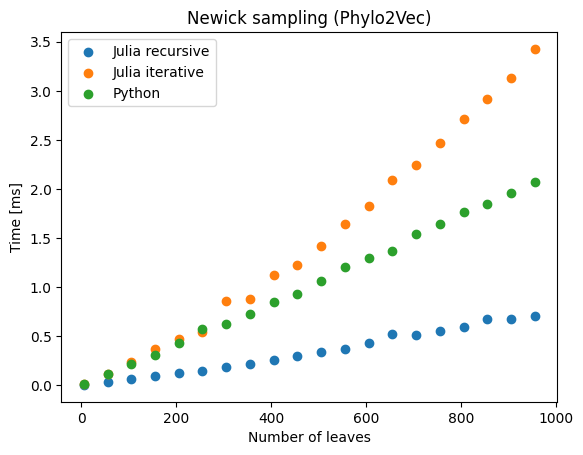

In [10]:
# compare to Julia
scatter(all_leaves, perfs_py, label="Python")
legend()
gcf()

### Benchmarks for table

In [11]:
## try other approach

py"""
from phylo2vec.base import to_newick
from phylo2vec.utils import sample
import timeit

# Sample a 1024-leaf tree
v = sample(1024)
# Compile
to_newick(v)

# Run timeit
n = 1000
res = timeit.timeit(lambda: to_newick(v), number=n) / n
"""

println(round(py"res * 1000", digits=2), " ms")

1.8 ms


In [22]:
@benchmark to_newick(sample_v(nleaves)) setup=(nleaves=512)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  228.200 μs …   3.232 ms  ┊ GC (min … max): 0.00% … 86.58%
 Time  (median):     293.000 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   326.234 μs ± 242.414 μs  ┊ GC (mean ± σ):  7.42% ±  8.93%

  ▅█▇▅▃▂▁                                                       ▂
  █████████▇▆▄▃▁▁▁▁▁▁▁▃▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅ █
  228 μs        Histogram: log(frequency) by time       2.41 ms <

 Memory estimate: 390.00 KiB, allocs estimate: 5139.

In [24]:
@benchmark to_newick(sample_v(nleaves)) setup=(nleaves=1024)

BenchmarkTools.Trial: 6501 samples with 1 evaluation.
 Range (min … max):  515.800 μs …   3.958 ms  ┊ GC (min … max): 0.00% … 62.86%
 Time  (median):     691.300 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   764.440 μs ± 365.083 μs  ┊ GC (mean ± σ):  7.49% ± 12.00%

  ▁▅▇██▇▇▆▅▃▂▂▁                                                 ▂
  ███████████████▇▇▆▅▅▁▁▄▃▁▁▄▁▃▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇█████ █
  516 μs        Histogram: log(frequency) by time       2.83 ms <

 Memory estimate: 931.97 KiB, allocs estimate: 10266.

In [25]:
@benchmark sample_v(nleaves) setup=(nleaves=512)

BenchmarkTools.Trial: 10000 samples with 9 evaluations.
 Range (min … max):  2.411 μs … 232.944 μs  ┊ GC (min … max): 0.00% … 97.37%
 Time  (median):     2.989 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.376 μs ±   5.594 μs  ┊ GC (mean ± σ):  4.24% ±  2.56%

        ▁▆█▃▂                                                  
  ▁▂▂▃▄▆█████▆▅▃▃▂▂▂▂▂▂▂▂▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  2.41 μs         Histogram: frequency by time        6.14 μs <

 Memory estimate: 4.12 KiB, allocs estimate: 1.

In [26]:
@benchmark sample_v(nleaves) setup=(nleaves=1024)

BenchmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):  4.871 μs … 268.257 μs  ┊ GC (min … max): 0.00% … 94.00%
 Time  (median):     5.900 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.494 μs ±   5.969 μs  ┊ GC (mean ± σ):  2.39% ±  2.64%

       ▇█▄▁                                                    
  ▁▂▃▄▇████▆▅▄▄▄▄▅▅▄▄▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  4.87 μs         Histogram: frequency by time        12.4 μs <

 Memory estimate: 8.12 KiB, allocs estimate: 1.

In [7]:
newick = to_newick(sample_v(512))
@benchmark to_vector(newick) setup=(newick=$newick)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  352.600 μs …   3.573 ms  ┊ GC (min … max):  0.00% … 76.51%
 Time  (median):     423.700 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   492.456 μs ± 325.271 μs  ┊ GC (mean ± σ):  11.35% ± 13.77%

  ▅██▆▅▄▃▂▁                                               ▁▁    ▂
  ████████████▇▇▄▅▅▅▁▄▃▃▃▁▃▁▃▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▇█████ █
  353 μs        Histogram: log(frequency) by time       2.23 ms <

 Memory estimate: 1.37 MiB, allocs estimate: 3086.

In [6]:
newick = to_newick(sample_v(1024))
@benchmark to_vector(newick) setup=(newick=$newick)

BenchmarkTools.Trial: 2865 samples with 1 evaluation.
 Range (min … max):  1.306 ms …   6.188 ms  ┊ GC (min … max):  0.00% … 63.41%
 Time  (median):     1.453 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   1.740 ms ± 583.256 μs  ┊ GC (mean ± σ):  10.89% ± 16.45%

  ▂▆█▆▄▄▄▃▃▃▃▂▁▁▁                 ▂▃▂▁                        ▁
  ████████████████▇▇▇▇▇▆▇█▇▆█▆▇▅▅▇████▇▇█▆█▇▇▇▇█▇▆▆▄▃▅▅▃▃▄▁▁▅ █
  1.31 ms      Histogram: log(frequency) by time      3.81 ms <

 Memory estimate: 5.54 MiB, allocs estimate: 6166.